In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
from google.colab import drive


zip_file_path = '/content/drive/MyDrive/codeBERT-20240522T154600Z-001 (1).zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/tesi')

# CodeBERT for Code Classification

In this notebook, we use CodeBERT to build the *Vulnerabilities Detector* system.

1.   For Classification, notebook will be use *run_class.py* script.
2.   For Translation, notebook will be use *run.py* script.




### Libraries

In [2]:
# SETUP
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.14.*"
!pip install "tf-models-official==2.14.*"
!pip install torch
!pip install transformers
!pip install filelock
import os, shutil, json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.15.1
    Uninstalling tf_keras-2.15.1:
      Successfully uninstalled tf_keras-2.15.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflo

### Dataset

In [3]:
# GET THE DATASET DIVERSEVUL
f = open('/content/drive/MyDrive/DiverseVul.VulnerableCode.json')
data = json.load(f)
dv = pd.DataFrame(data)
#dv.drop(['_id', 'cwe','project','size'], axis='columns', inplace=True)
dv.info()
dv.groupby('target').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330492 entries, 0 to 330491
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   _id      330492 non-null  object
 1   func     330492 non-null  object
 2   target   330492 non-null  int64 
 3   cwe      330492 non-null  object
 4   project  330492 non-null  object
 5   size     330492 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 15.1+ MB


size                                                         
           count        mean         std  min   25%   50%    75%      max
target                                                                   
0       311547.0   39.257531  104.818767  1.0   8.0  18.0   40.0  24047.0
1        18945.0  114.707786  312.548557  1.0  22.0  50.0  113.0  23939.0

In [4]:
dv['func'].iloc[0]

'static void cirrus_invalidate_region(CirrusVGAState * s, int off_begin,\n\t\t\t\t     int off_pitch, int bytesperline,\n\t\t\t\t     int lines)\n{\n    int y;\n    int off_cur;\n    int off_cur_end;\n\n    for (y = 0; y < lines; y++) {\n\toff_cur = off_begin;\n\toff_cur_end = off_cur + bytesperline;\n\toff_cur &= TARGET_PAGE_MASK;\n\twhile (off_cur < off_cur_end) {\n\t    cpu_physical_memory_set_dirty(s->vram_offset + off_cur);\n\t    off_cur += TARGET_PAGE_SIZE;\n\t}\n\toff_begin += off_pitch;\n    }\n}'

### Pre-processing

In [5]:
import re
import pandas as pd
from tqdm import tqdm

def remove_comments(code):
    # Rimuovi commenti su una sola riga
    code = re.sub(r'//.*', '', code)
    # Rimuovi commenti su più righe
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    return code

def remove_includes_defines(code):
    # Rimuovi include
    code = re.sub(r'#include\s*".*?"', '', code)
    # Rimuovi define
    code = re.sub(r'#define.*', '', code)
    return code

def remove_string(f):
  # f is a string
	# This function removes printed strings: "..."
	f = re.sub("[\"]+(.)+[\"]","\"STR\"",f)
	return f

# Supponiamo che il DataFrame originale si chiami df
df = dv.copy()

# Liste per i nuovi valori
n_tokens, new_strings = [], []

for i in tqdm(range(len(df))):
    file_string = df['func'].iloc[i]
    # Calcola il numero di token prima del preprocessing
    n_tokens.append(len(file_string.split()))
    # Applica le funzioni di preprocessing
    file_string = remove_comments(remove_includes_defines(remove_string(file_string)))
    new_strings.append(file_string)

# Aggiungi le nuove colonne al DataFrame
df['lengths'] = n_tokens
df['func'] = new_strings
df = df[df['lengths']>=5  ]
df = df[df['lengths']<=256]
df.sort_values('lengths')
df = df.drop(['lengths'], axis=1)
df = df.reset_index(drop=True)

df

100%|██████████| 330492/330492 [00:43<00:00, 7567.87it/s] 


,_id,func,target,cwe,project,size
0,{'$oid': '6527b17399826ba7e58eb15c'},static void cirrus_invalidate_region(CirrusVGA...,1,[CWE-787],qemu,19
1,{'$oid': '6527b17399826ba7e58eb176'},static int pwc_video_close(struct inode *inode...,1,[CWE-399],linux-2.6,42
2,{'$oid': '6527b17399826ba7e58eb175'},"static int putreg(struct task_struct *child,\n...",1,[CWE-264],linux-2.6,60
3,{'$oid': '6527b17399826ba7e58eb160'},static void cirrus_mem_writeb_mode4and5_16bpp(...,1,[CWE-787],qemu,24
4,{'$oid': '6527b17399826ba7e58eb168'},"static int fat_dir_ioctl(struct inode * inode,...",1,[],linux-2.6,44
...,...,...,...,...,...,...
291422,{'$oid': '6527b2fa99826ba7e593bc18'},"auth_passdb_preinit(struct auth *auth, const s...",0,[CWE-284],core,56
291423,{'$oid': '6527b2fa99826ba7e593bc1c'},"int CMS_data(CMS_ContentInfo *cms, BIO *out, u...",0,"[CWE-399, CWE-703]",openssl,16
291424,{'$oid': '6527b2fa99826ba7e593bc29'},static int cms_kari_set1_pkey(CMS_ContentInfo ...,0,"[CWE-399, CWE-703]",openssl,24
291425,{'$oid': '6527b2fa99826ba7e593bc2b'},static int cms_signerinfo_verify_cert(CMS_Sign...,0,"[CWE-399, CWE-703]",openssl,36


In [10]:
print("Before: ",dv['func'].iloc[0])
print("After:  ",df['func'].iloc[0])

Before:  static void cirrus_invalidate_region(CirrusVGAState * s, int off_begin,
				     int off_pitch, int bytesperline,
				     int lines)
{
    int y;
    int off_cur;
    int off_cur_end;

    for (y = 0; y < lines; y++) {
	off_cur = off_begin;
	off_cur_end = off_cur + bytesperline;
	off_cur &= TARGET_PAGE_MASK;
	while (off_cur < off_cur_end) {
	    cpu_physical_memory_set_dirty(s->vram_offset + off_cur);
	    off_cur += TARGET_PAGE_SIZE;
	}
	off_begin += off_pitch;
    }
}
After:   static void cirrus_invalidate_region(CirrusVGAState * s, int off_begin,
				     int off_pitch, int bytesperline,
				     int lines)
{
    int y;
    int off_cur;
    int off_cur_end;

    for (y = 0; y < lines; y++) {
	off_cur = off_begin;
	off_cur_end = off_cur + bytesperline;
	off_cur &= TARGET_PAGE_MASK;
	while (off_cur < off_cur_end) {
	    cpu_physical_memory_set_dirty(s->vram_offset + off_cur);
	    off_cur += TARGET_PAGE_SIZE;
	}
	off_begin += off_pitch;
    }
}


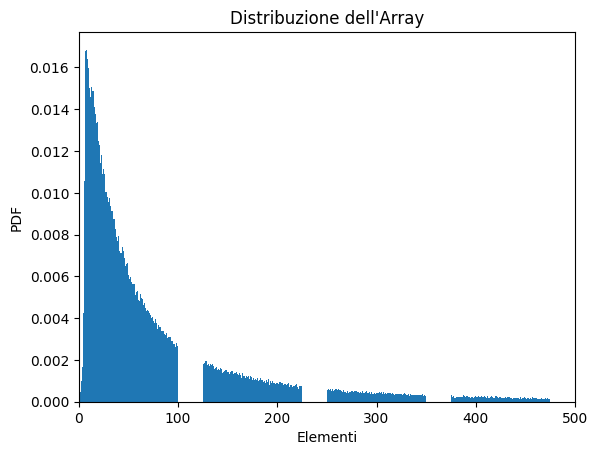

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

def grafico_distribuzione(array):
    conteggio = Counter(array)

    etichette, valori = zip(*conteggio.items())

    # Normalizza i valori per ottenere una PDF
    somma_totale = sum(valori)
    pdf = [frequenza / somma_totale for frequenza in valori]

    plt.bar(etichette, pdf)
    plt.xlabel('Elementi')
    plt.ylabel('PDF')
    plt.title('Distribuzione dell\'Array')
    plt.xlim(0, 500)
    plt.show()
grafico_distribuzione(n_tokens)

In [12]:
union = df.copy()
vv = df[df['target']==1]
nv = df[df['target']==0].sample(n=len(df[df['target']==1]))
union = pd.concat([vv,nv])
union = union.sample(frac = 1)
union = union.reset_index(drop=True)

In [13]:
union

# Conta i valori della colonna 'target'
count_target = union['target'].value_counts()

# Stampa i risultati
print("Numero di entry con target = 1:", count_target[1])
print("Numero di entry con target = 0:", count_target[0])

Numero di entry con target = 1: 12531
Numero di entry con target = 0: 12531


### Split

In [14]:
df = union.copy()

In [15]:
# SPLIT IN 3 SET AND STRATITY
df_v = df[df['target']==1]
split1 = int(len(df_v)*0.9)
split2 = int(len(df_v)*0.95)
df_v_train= df_v[:split1]
df_v_valid= df_v[split1:split2]
df_v_test = df_v[split2:]

df_n = df[df['target']==0]
split1 = int(len(df_n)*0.9)
split2 = int(len(df_n)*0.95)
df_n_train= df_n[:split1]
df_n_valid= df_n[split1:split2]
df_n_test = df_n[split2:]

# MERGE AND SHUFFLE ITEMS
df_train = pd.concat([df_v_train,df_n_train])
df_train = df_train.sample(frac = 1)
df_valid = pd.concat([df_v_valid,df_n_valid])
df_valid = df_valid.sample(frac = 1)
df_test  = pd.concat([df_v_test, df_n_test])
df_test  = df_test.sample(frac = 1)

print("TOTAL:",len(df))

print("TRAIN VUL    :",len(df_train[df_train['target']==0]))
print("TRAIN NON VUL:",len(df_train[df_train['target']==1]))
print("VALID VUL    :",len(df_valid[df_valid['target']==0]))
print("VALID NON VUL:",len(df_valid[df_valid['target']==1]))
print("TEST VUL     :",len(df_test[df_test['target']==0]))
print("TEST NON VUL :",len(df_test[df_test['target']==1]))


#df_train.to_json("/content/drive/MyDrive/new_data_code/train.json",orient='records')
#df_test.to_json("/content/drive/MyDrive/new_data_code/test.json",orient='records')
#df_valid.to_json("/content/drive/MyDrive/new_data_code/valid.json",orient='records')

#train = df_train.to_json("/content/drive/MyDrive/new_data_code/train.json.seq2seq",orient="records")
#valid = df_valid.to_json("/content/drive/MyDrive/new_data_code/valid.json.seq2seq",orient="records")
#test  = df_test.to_json("/content/drive/MyDrive/new_data_code/test.json.seq2seq"  ,orient="records")

TOTAL: 25062
TRAIN VUL    : 11277
TRAIN NON VUL: 11277
VALID VUL    : 627
VALID NON VUL: 627
TEST VUL     : 627
TEST NON VUL : 627


In [16]:
import json

In [18]:
df = df_train.reset_index(drop=True)
df.target = df.target.astype(object)
json_arr = []
for i in range(len(df)):
    #json_data = {"code": df['code'].iloc[i].strip(), "code_tokens": df['code_tokens'].iloc[i], "docstring": df['docstring'].iloc[i].strip(), "docstring_tokens": df['docstring_tokens'].iloc[i]}
    json_data = {"code": df['func'].iloc[i].strip(), "label": df['target'].iloc[i]}
    json_temp = json.dumps(json_data)
    json_arr.append(json_temp)
output_file = open("/content/drive/MyDrive/Tesi/train.jsonl", 'w')
json_string = ""#"["
for i in tqdm(range(len(json_arr))):
    if(i < len(json_arr)-1):
        json_string = json_string + json_arr[i] + '\n'
    else:
        json_string = json_string + json_arr[i]
json_string = json_string + "\n"
output_file.write(json_string)
output_file.close()

100%|██████████| 22554/22554 [00:39<00:00, 573.85it/s]


In [19]:
df = df_test.reset_index(drop=True)
df.target = df.target.astype(object)
json_arr = []
for i in range(len(df)):
    #json_data = {"code": df['code'].iloc[i].strip(), "code_tokens": df['code_tokens'].iloc[i], "docstring": df['docstring'].iloc[i].strip(), "docstring_tokens": df['docstring_tokens'].iloc[i]}
    json_data = {"code": df['func'].iloc[i].strip(), "label": df['target'].iloc[i]}
    json_temp = json.dumps(json_data)
    json_arr.append(json_temp)
output_file = open("/content/drive/MyDrive/Tesi/test.jsonl", 'w')
json_string = ""#"["
for i in tqdm(range(len(json_arr))):
    if(i < len(json_arr)-1):
        json_string = json_string + json_arr[i] + '\n'
    else:
        json_string = json_string + json_arr[i]
json_string = json_string + "\n"
output_file.write(json_string)
output_file.close()

100%|██████████| 1254/1254 [00:00<00:00, 19499.93it/s]


In [20]:
df = df_valid.reset_index(drop=True)
df.target = df.target.astype(object)
json_arr = []
for i in range(len(df)):
    #json_data = {"code": df['code'].iloc[i].strip(), "code_tokens": df['code_tokens'].iloc[i], "docstring": df['docstring'].iloc[i].strip(), "docstring_tokens": df['docstring_tokens'].iloc[i]}
    json_data = {"code": df['func'].iloc[i].strip(), "label": df['target'].iloc[i]}
    json_temp = json.dumps(json_data)
    json_arr.append(json_temp)
output_file = open("/content/drive/MyDrive/Tesi/valid.jsonl", 'w')
json_string = ""#"["
for i in tqdm(range(len(json_arr))):
    if(i < len(json_arr)-1):
        json_string = json_string + json_arr[i] + '\n'
    else:
        json_string = json_string + json_arr[i]
json_string = json_string + "\n"
output_file.write(json_string)
output_file.close()

100%|██████████| 1254/1254 [00:00<00:00, 29658.44it/s]


### Import Transformers Features

In [21]:
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model     = RobertaModel.from_pretrained("microsoft/codebert-base")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

### Model codeBERT (translation)

In [ ]:
#lang="python"
lr=5e-5 #5e-5
batch_size=32 #64
beam_size=10
source_length=256
target_length=20
#data_dir="drive/MyDrive/data/code2nl/CodeSearchNet"
output_dir='/content/drive/MyDrive/codeBERT/output' #output_dir=f"model/{lang}"
train_file='/content/drive/MyDrive/codeBERT/train.json'  #f"{data_dir}/{lang}/train.jsonl"
dev_file='/content/drive/MyDrive/codeBERT/valid.json'  #f"{data_dir}/{lang}/valid.jsonl"
test_file='/content/drive/MyDrive/codeBERT/test.json'  #f"{data_dir}/{lang}/valid.jsonl"
eval_steps=150    #350
train_steps=1000  #3000
pretrained_model="microsoft/codebert-base"
test_model=f'/content/drive/MyDrive/codeBERT/output/checkpoint-best-bleu/pytorch_model.bin'

# TRAINING

!python /content/drive/MyDrive/codeBERT/run.py --do_train --do_eval --model_type roberta --model_name_or_path $pretrained_model --train_file $train_file --dev_filename $dev_file --output_dir $output_dir --max_source_length $source_length --max_target_length $target_length --beam_size $beam_size --train_batch_size $batch_size --eval_batch_size $batch_size --learning_rate $lr --train_steps $train_steps --eval_steps $eval_steps

05/28/2024 19:35:51 - INFO - __main__ -   Namespace(model_type='roberta', model_name_or_path='microsoft/codebert-base', output_dir='/content/drive/MyDrive/codeBERT/output', load_model_path=None, train_filename='/content/drive/MyDrive/train.json', dev_filename='/content/drive/MyDrive/valid.json', test_filename=None, config_name='', tokenizer_name='', max_source_length=256, max_target_length=20, do_train=True, do_eval=True, do_test=False, do_lower_case=False, no_cuda=False, train_batch_size=32, eval_batch_size=32, gradient_accumulation_steps=1, learning_rate=5e-05, beam_size=10, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, eval_steps=150, train_steps=1000, warmup_steps=0, local_rank=-1, seed=42)
05/28/2024 19:35:51 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will

In [ ]:
# TESTING

!python /content/codeBERT/run.py --do_test --model_type roberta --model_name_or_path $pretrained_model --load_model_path $test_model --dev_filename $dev_file --test_filename $test_file --output_dir $output_dir --max_source_length $source_length --max_target_length $target_length --beam_size $beam_size --eval_batch_size $batch_size

### Model codeBERT (classification)

In [22]:
lr=1e-5
train_batch_size=8
eval_batch_size=16
max_grad_norm=1.0
beam_size=10
block_size=256
output_dir='/content/drive/MyDrive/Tesi/output'
train_file='/content/drive/MyDrive/Tesi/train.jsonl'
dev_file='/content/drive/MyDrive/Tesi/valid.jsonl'
test_file='/content/drive/MyDrive/Tesi/test.jsonl'
pretrained_model="microsoft/codebert-base"
tokenizer_name=pretrained_model
model_name_or_path=pretrained_model
num_train_epochs=5
seed=123456 #test_model=f'/content/drive/MyDrive/codeBERT/output/checkpoint-best-acc/model.bin'


!python /content/drive/MyDrive/Tesi/codeBERT/run_class.py --do_train --tokenizer_name $tokenizer_name --model_name_or_path $pretrained_model --train_data_file $train_file --num_train_epochs $num_train_epochs --eval_data_file $dev_file --output_dir $output_dir --block_size $block_size --train_batch_size $train_batch_size --eval_batch_size $eval_batch_size --learning_rate $lr --seed $seed --max_grad_norm $max_grad_norm 2>&1 | tee train.log

06/06/2024 07:50:30 - WARNING - __main__ -   device: cuda, n_gpu: 1
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
06/06/2024 07:50:33 - INFO - __main__ -   Training/evaluation parameters Namespace(train_data_file='/content/drive/MyDrive/Tesi/train.jsonl', output_dir='/content/drive/MyDrive/Tesi/output', eval_data_file='/content/drive/MyDrive/Tesi/valid.jsonl', test_data_file=None, model_

In [24]:
!python /content/drive/MyDrive/Tesi/codeBERT/run_class.py --do_test  --do_eval --tokenizer_name=microsoft/codebert-base --model_name_or_path=microsoft/codebert-base --train_data_file=$train_file --eval_data_file=$dev_file --test_data_file=$test_file --output_dir=$output_dir --block_size=256 --eval_batch_size=32 2>&1 | tee test.log

06/06/2024 09:25:03 - WARNING - __main__ -   device: cuda, n_gpu: 1
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
06/06/2024 09:25:05 - INFO - __main__ -   Training/evaluation parameters Namespace(train_data_file='/content/drive/MyDrive/Tesi/train.jsonl', output_dir='/content/drive/MyDrive/Tesi/output', eval_data_file='/content/drive/MyDrive/Tesi/valid.jsonl', test_data_file='/content/dr

### Evaluation

In [25]:
from sklearn.metrics import classification_report

y_pred = open('/content/drive/MyDrive/Tesi/output/predictions.txt').readlines()
y_true = pd.read_json("/content/drive/MyDrive/Tesi/test.jsonl", lines=True)
y_true = list(y_true['label'])
for i in range(len(y_pred)):
  y_pred[i] = int(y_pred[i].replace("\n",""))
target_names = ['not vulnerable', 'vulnerable',]
print(classification_report(y_true, y_pred, target_names=target_names,digits=4))

                precision    recall  f1-score   support

not vulnerable     0.7018    0.7544    0.7271       627
    vulnerable     0.7345    0.6794    0.7059       627

      accuracy                         0.7169      1254
     macro avg     0.7181    0.7169    0.7165      1254
  weighted avg     0.7181    0.7169    0.7165      1254



                precision    recall  f1-score   support

not vulnerable     0.7018    0.7544    0.7271       627
    vulnerable     0.7345    0.6794    0.7059       627

      accuracy                         0.7169      1254
     macro avg     0.7181    0.7169    0.7165      1254
  weighted avg     0.7181    0.7169    0.7165      1254



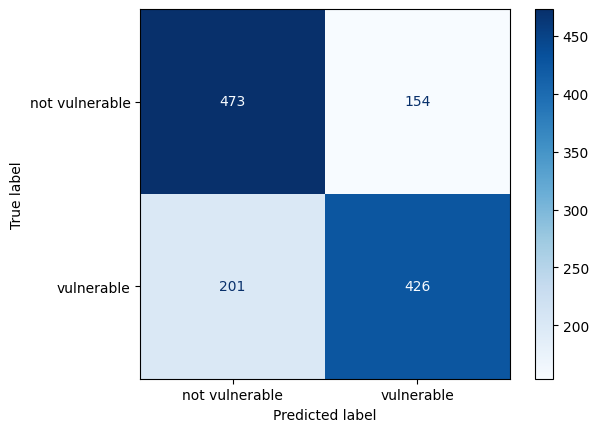

In [26]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Carica le predizioni dal file
with open('/content/drive/MyDrive/Tesi/output/predictions.txt') as f:
    y_pred = f.readlines()
y_pred = [int(pred.strip()) for pred in y_pred]

# Carica le etichette vere dal file JSONL
y_true = pd.read_json("/content/drive/MyDrive/Tesi/test.jsonl", lines=True)['label'].tolist()

# Definisci i nomi delle classi
target_names = ['not vulnerable', 'vulnerable']

# Stampa il report di classificazione
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()
